# Summary Statistics

This notebook displays summary statistics of patient records,
comparing multiple snapshots extracted by the `cohortextractor` action.

## Preliminaries

In [1]:
from IPython.display import display, Markdown
import itertools
import matplotlib
import pandas
from pathlib import Path

In [2]:
%matplotlib inline
matplotlib.style.use("seaborn")

In [3]:
BASE_DIR = Path("../output")

In [4]:
def read_feather(f_path):
    return pandas.read_feather(f_path).assign(
        is_registered=lambda x: x.is_registered.astype(bool),
        date_deregistered=lambda x: pandas.to_datetime(x.date_deregistered, format="%Y-%m"),
        f_name=f_path.name,  # We need the file name because we will concatenate the csv files
    )

In [5]:
# Concatenate the feather files in `BASE_DIR`
records = pandas.concat(read_feather(x) for x in BASE_DIR.iterdir() if x.name.endswith(".feather"))

In [6]:
# Unfortunately, `pandas.concat` converts categorical columns to string (object) columns,
# if the set of categories are different. Consequently, we must cast the `f_name` column
# to a categorical column here.
records.f_name = records.f_name.astype("category")

In [7]:
# Patient IDs should be unique within each file
assert records.set_index(["f_name", "patient_id"]).index.is_unique

Discretise patient ages into patient age groups of width `age_group_width`.

In [8]:
age_group_width = 10

In [9]:
records["age_group"] = pandas.cut(
    records.age,
    range(0, records.age.max() + age_group_width, age_group_width),
    right=False,  # Don't include the right-edge, meaning [lower, upper) or lower <= x < upper
)

## Patients

How many patients are in each file?

---
**Aside**: There are several ways to count groups in Pandas. For consistency, we will:

* locate the columns of interest
* group by these columns
* count the number of rows

For readability, we will also put each step on a separate line.

---

In [10]:
(records
    .loc[:, ["f_name", "patient_id"]]
    .groupby("f_name")
    .count())

,patient_id
f_name,
input-last.feather,1000
input.feather,1000


How many patients are in each file, by sex?

In [11]:
(records
    .loc[:, ["f_name", "sex", "patient_id"]]
    .groupby(["f_name", "sex"])
    .count())

patient_id
f_name             sex            
input-last.feather F           492
                   M           508
input.feather      F           503
                   M           497

How many patients are in each file, by age group?

In [12]:
by_age_group = (records
    .loc[:, ["age_group", "f_name", "patient_id"]]
    .groupby(["age_group", "f_name"])
    .count())

In [13]:
by_age_group.unstack()

patient_id              
f_name    input-last.feather input.feather
age_group                                 
[0, 10)                  117           116
[10, 20)                  94           109
[20, 30)                 158           147
[30, 40)                 128           128
[40, 50)                 129           130
[50, 60)                 149           118
[60, 70)                  95           109
[70, 80)                  74            91
[80, 90)                  47            42
[90, 100)                  9            10

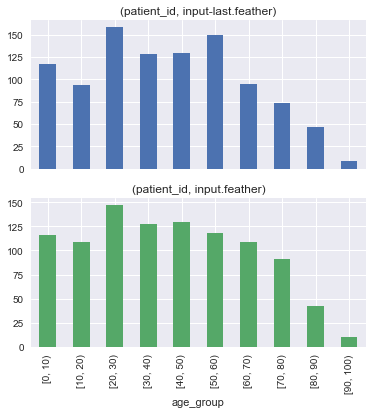

In [14]:
_ = (by_age_group
    .unstack()
    .plot.bar(subplots=True, figsize=(6, 6), legend=False))

How many patients in each file deregistered, by month?

In [15]:
by_date_deregistered = (records
    .loc[:, ["date_deregistered", "f_name", "patient_id"]]
    .groupby(["date_deregistered", "f_name"])
    .count())

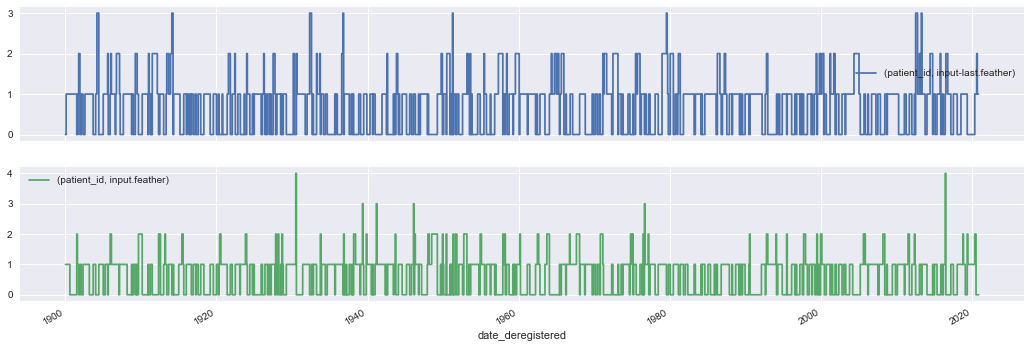

In [16]:
_ = (by_date_deregistered
    .unstack()
    .plot.line(subplots=True, figsize=(18, 6), drawstyle="steps-post"))

How many patients are in each file, by registration?

In [17]:
(records
    .loc[:, ["f_name", "is_registered", "patient_id"]]
    .groupby(["f_name", "is_registered"])
    .count())

patient_id
f_name             is_registered            
input-last.feather False                  30
                   True                  970
input.feather      False                  30
                   True                  970

For each combination of files, how many patients are in:

* both files
* the first file but not the second file
* the second file but not the first file

---
**Aside**: We compare each combination of files to future-proof our notebook.
Because order isn't significant, we use `itertools.combinations` rather than `itertools.permutations`.

---

In [18]:
# Let's revisit sets.
# https://docs.python.org/3.8/library/stdtypes.html#set
set_1 = {1, 2, 3}
set_2 = {3, 4, 5}
assert set_1 & set_2 == {3}  # In set 1 and in set 2 (intersection)
assert set_1 - set_2 == {1, 2}  # In set 1, but not in set 2 (difference)
assert set_2 - set_1 == {4, 5}  # In set 2, but not in set 1 (difference)
del set_1
del set_2

In [19]:
for f_name_0, f_name_1 in itertools.combinations(records.f_name.cat.categories, 2):
    patient_id_0 = set(records.patient_id[records.f_name == f_name_0])
    patient_id_1 = set(records.patient_id[records.f_name == f_name_1])

    display(Markdown(f"{len(patient_id_0 & patient_id_1)} patients are in *{f_name_0}* and in *{f_name_1}*."))
    display(Markdown(f"{len(patient_id_0 - patient_id_1)} patients are in *{f_name_0}* but not in *{f_name_1}*."))
    display(Markdown(f"{len(patient_id_1 - patient_id_0)} patients are in *{f_name_1}* but not in *{f_name_0}*."))

86 patients are in *input-last.feather* and in *input.feather*.

914 patients are in *input-last.feather* but not in *input.feather*.

914 patients are in *input.feather* but not in *input-last.feather*.

## Practices

How many practices are in each file?

In [20]:
(records
    .loc[:, ["f_name", "practice_pseudo_id"]]
    .drop_duplicates()  # Remember that rows are patient records.
    .groupby("f_name")
    .count())

,practice_pseudo_id
f_name,
input-last.feather,292
input.feather,268
